# Final Regression Project — Airbnb NYC 2019 (AB_NYC_2019.csv)

This notebook is structured to match the assignment rubric:

1) **Dataset Description** (source, structure, key variables)  
2) **Analysis Objective**  
3) **Model Comparison** (Linear vs Ridge vs Lasso vs ElasticNet)  
4) **Findings & Interpretation** (meaningful insights)  
5) **Evaluation & Future Steps** (limitations + improvements)


In [46]:
# Imports (Colab-friendly)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [47]:
# Load data
DATA_PATH = "AB_NYC_2019.csv"

if not os.path.exists(DATA_PATH):
    # In Google Colab you can upload the CSV to the runtime
    try:
        from google.colab import files  # type: ignore
        print("Upload AB_NYC_2019.csv...")
        files.upload()
    except Exception:
        print("AB_NYC_2019.csv not found. Please upload it to the current directory.")

data = pd.read_csv(DATA_PATH)
data.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## [1] Dataset Description

**Dataset:** Public NYC Airbnb listings dataset for 2019 (often distributed as `AB_NYC_2019.csv`, e.g., via Kaggle/InsideAirbnb mirrors).

In this section we describe:
- dataset size (rows/columns)
- key variables (numeric + categorical)
- the target variable (**price**)
- missing values and what they mean


In [48]:
data.shape

(48895, 16)

### Dataset size (rows & columns)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [50]:
data.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [51]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,48895.0,NaN,NaN,NaN,19017143.23618,10983108.38561,2539.0,9471945.0,19677284.0,29152178.5,36487245.0
name,48879,47905,Hillside Hotel,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,48895.0,NaN,NaN,NaN,67620010.64661,78610967.032667,2438.0,7822033.0,30793816.0,107434423.0,274321313.0
host_name,48874,11452,Michael,417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group,48895,5,Manhattan,21661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood,48895,221,Williamsburg,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,48895.0,NaN,NaN,NaN,40.728949,0.05453,40.49979,40.6901,40.72307,40.763115,40.91306
longitude,48895.0,NaN,NaN,NaN,-73.95217,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
room_type,48895,3,Entire home/apt,25409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,48895.0,NaN,NaN,NaN,152.720687,240.15417,0.0,69.0,106.0,175.0,10000.0


### Target variable (`price`)

In [52]:
data["price"].describe()


,price
count,48895.000000
mean,152.720687
std,240.154170
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


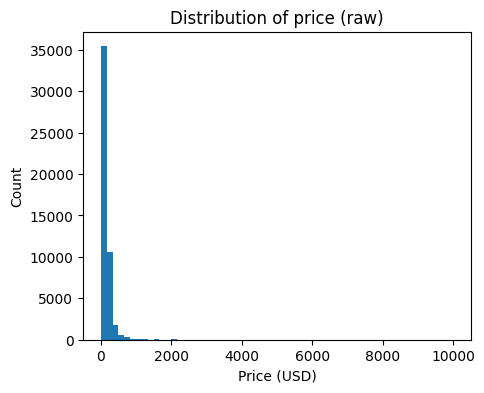

In [53]:
plt.figure(figsize=(5,4))
plt.hist(data["price"], bins=60)
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.title("Distribution of price (raw)")
plt.show()


### Quick visualizations (relationships)

These charts help us see how `price` relates to a few important variables.
To keep it fast, we plot only a random sample (max 5,000 rows).


In [ ]:
# Take a small sample for faster plotting
sample = data.sample(5000, random_state=42) if len(data) > 5000 else data

# 1) Log price distribution (often easier for linear models)
plt.figure(figsize=(5,4))
plt.hist(np.log1p(sample['price']), bins=60)
plt.xlabel('log1p(price)')
plt.ylabel('Count')
plt.title('Distribution of log1p(price)')
plt.show()

# 2) Scatter: minimum_nights vs price (use log scale for y)
if 'minimum_nights' in sample.columns:
    plt.figure(figsize=(5,4))
    plt.scatter(sample['minimum_nights'], sample['price'], s=8, alpha=0.25)
    plt.yscale('log')
    plt.xlabel('minimum_nights')
    plt.ylabel('price (log scale)')
    plt.title('minimum_nights vs price')
    plt.show()

# 3) Boxplot-like summary: average price by room_type
if 'room_type' in sample.columns:
    room_means = sample.groupby('room_type')['price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    plt.bar(room_means.index.astype(str), room_means.values)
    plt.xticks(rotation=30, ha='right')
    plt.ylabel('Average price (USD)')
    plt.title('Average price by room_type')
    plt.show()

# 4) Average price by neighbourhood_group (usually small number of groups)
if 'neighbourhood_group' in sample.columns:
    ng_means = sample.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    plt.bar(ng_means.index.astype(str), ng_means.values)
    plt.xticks(rotation=30, ha='right')
    plt.ylabel('Average price (USD)')
    plt.title('Average price by neighbourhood_group')
    plt.show()


### D) Missing values

In [54]:
data.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


## [2] Analysis Objective

**Goal:** Predict Airbnb nightly listing price (USD) in NYC using listing attributes, and explain which features are most associated with higher/lower prices.

Because `price` is right-skewed, we model **`log1p(price)`** to make linear models more stable and to reduce the influence of extreme prices.


### Data Cleaning & Preparation (supporting step)

We clean missing values, remove impossible prices, and create simple review-related features.
This is not a separate rubric item, but it supports a fair model comparison.


In [55]:
# Basic checks
print("Duplicates:", data.duplicated().sum())
print("Rows:", len(data))


Duplicates: 0
Rows: 48895


In [56]:
# Missing reviews_per_month means 'no reviews' for this dataset, so fill with 0
if "reviews_per_month" in data.columns:
    data["reviews_per_month"] = data["reviews_per_month"].fillna(0)


In [57]:
# Feature engineering from last_review (if present)
# We convert to datetime, then create:
# - has_review: 1 if there is a review date, else 0
# - days_since_last_review: days from the most recent review date (NaT -> NaN)
if "last_review" in data.columns:
    data["last_review"] = pd.to_datetime(data["last_review"], errors="coerce")
    data["has_review"] = data["last_review"].notna().astype(int)
    ref_date = data["last_review"].max()
    data["days_since_last_review"] = (ref_date - data["last_review"]).dt.days

# After making features, we can drop last_review to keep the model purely numeric/categorical
if "last_review" in data.columns:
    data = data.drop(columns=["last_review"])


In [58]:
# Remove impossible target values (price <= 0)
data = data.loc[data["price"] > 0].copy()
print("After removing price<=0:", data.shape)


After removing price<=0: (48884, 17)


In [59]:
# Drop ID / name columns that are not useful for prediction
col_drop = ["host_id", "id", "name", "host_name"]
data = data.drop(columns=[c for c in col_drop if c in data.columns])

# Define target and features
y = np.log1p(data["price"])
X = data.drop(columns=["price"]).copy()

X.shape, y.shape


((48884, 12), (48884,))

In [60]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (34218, 12) Test: (14666, 12)


## [3] Model Comparison

We compare multiple **linear regression** variations using the same train/test split:

- **LinearRegression** (baseline linear model)
- **Ridge** (L2 regularization: helps with multicollinearity)
- **Lasso** (L1 regularization: can shrink some coefficients to 0)
- **ElasticNet** (mix of L1 + L2)
- **Polynomial + Ridge (degree=2)** (a simple nonlinear extension, still a linear regression model *after* feature expansion)

**Selection rule:** choose the model with the **lowest Test RMSE** on `log1p(price)` (and check R² as a support metric).

We also add an **optional** cross-validation step (3-fold) for the selected model to show robustness.


In [61]:
# Preprocessing:
# - Numeric columns: fill missing values + scale
# - Categorical columns: fill missing values + one-hot encode
#
# We create TWO preprocessors:
# 1) preprocess       : normal (no polynomial features)
# 2) preprocess_poly  : polynomial features (degree=2) ONLY for numeric columns

num_cols = X_train.select_dtypes(include=["number"]).columns
cat_cols = X_train.select_dtypes(exclude=["number"]).columns

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# Polynomial features for numeric columns (degree=2)
numeric_poly_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

preprocess_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_poly_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


In [62]:
# ---- Model comparison (beginner-friendly) ----
# We fit each model once (fast) using the same train/test split.

pipes = [
    ("LinearRegression",
     Pipeline([("preprocess", preprocess), ("model", LinearRegression())])),

    ("Ridge(alpha=1.0)",
     Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=1.0))])),

    ("Lasso(alpha=0.001)",
     Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=0.001, max_iter=20000))])),

    ("ElasticNet(alpha=0.001, l1_ratio=0.5)",
     Pipeline([("preprocess", preprocess), ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000))])),

    # Extra model: Polynomial features (degree 2) + Ridge
    ("Poly2 + Ridge(alpha=1.0)",
     Pipeline([("preprocess", preprocess_poly), ("model", Ridge(alpha=1.0))])),
]

rows = []
fitted_pipes = {}

for name, pipe in pipes:
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    rmse_log = np.sqrt(mean_squared_error(y_test, pred))
    mae_log = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    rows.append({
        "Model": name,
        "RMSE_log": rmse_log,
        "MAE_log": mae_log,
        "R2": r2,
    })
    fitted_pipes[name] = pipe

comparison = pd.DataFrame(rows).sort_values("RMSE_log").reset_index(drop=True)
comparison[["RMSE_log", "MAE_log", "R2"]] = comparison[["RMSE_log", "MAE_log", "R2"]].round(4)

display(comparison)

best_model_name = comparison.loc[0, "Model"]
best_model = fitted_pipes[best_model_name]
print("Selected best model:", best_model_name)


In [67]:
# ---- Evaluate the selected model (log scale + USD scale) ----
# We already fitted 'best_model' above. Now we evaluate it on the test set.

pred_log = best_model.predict(X_test)

rmse_log = np.sqrt(mean_squared_error(y_test, pred_log))
mae_log = mean_absolute_error(y_test, pred_log)
r2 = r2_score(y_test, pred_log)

# Convert back to USD for a more intuitive error
y_true_usd = np.expm1(y_test)
y_pred_usd = np.expm1(pred_log)

rmse_usd = np.sqrt(mean_squared_error(y_true_usd, y_pred_usd))
mae_usd = mean_absolute_error(y_true_usd, y_pred_usd)

print("Selected model:", best_model_name)
print(f"Test RMSE (log1p): {rmse_log:.4f}")
print(f"Test MAE  (log1p): {mae_log:.4f}")
print(f"Test R^2         : {r2:.4f}")
print(f"Test RMSE (USD)  : {rmse_usd:.2f}")
print(f"Test MAE  (USD)  : {mae_usd:.2f}")


('Ridge', {'model__alpha': 1})

In [68]:
# ---- (Optional) Cross-validation for robustness (3-fold) ----
# Cross-validation fits the model multiple times on different splits of the TRAIN data.
# It gives a more reliable estimate than a single train/test split.
#
# Note: CV can take longer. To keep it fast, we run CV on a smaller sample of the training data.

RUN_CV = False  # change to False if you want to skip this cell
CV_SAMPLE_SIZE = 8000  # use a smaller number for speed (e.g., 5000)

if RUN_CV:
    n = min(CV_SAMPLE_SIZE, len(X_train))
    X_cv = X_train.sample(n, random_state=42)
    y_cv = y_train.loc[X_cv.index]

    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    # neg_root_mean_squared_error returns NEGATIVE values, so we multiply by -1
    cv_scores = cross_val_score(
        best_model, X_cv, y_cv,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    cv_rmse = -cv_scores
    print(f"CV RMSE (log1p) mean: {cv_rmse.mean():.4f}")
    print(f"CV RMSE (log1p) std : {cv_rmse.std():.4f}")
else:
    print("Cross-validation skipped.")


Selected model: Ridge
Test RMSE (log1p): 0.4664
Test MAE  (log1p): 0.3375
Test R^2         : 0.5388
Test RMSE (USD)  : 180.65
Test MAE  (USD)  : 58.38


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## [4] Findings & Interpretation

We interpret the strongest positive/negative coefficients from the selected model.
Because the target is **log1p(price)**, coefficient signs indicate whether a feature is associated with **higher** or **lower** prices (all else equal).


In [69]:
# Extract and display top coefficients (only works for linear models with coef_)
model_step = best_model.named_steps["model"]
pre_step = best_model.named_steps["preprocess"]

feature_names = pre_step.get_feature_names_out()
coefs = model_step.coef_

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

top_pos = coef_df.sort_values("coef", ascending=False).head(15)[["feature", "coef"]]
top_neg = coef_df.sort_values("coef", ascending=True).head(15)[["feature", "coef"]]

print("Top positive coefficients (push price up):")
display(top_pos)

print("\nTop negative coefficients (push price down):")
display(top_neg)


Top positive coefficients (push price up):


,feature,coef
93,cat__neighbourhood_Fort Wadsworth,0.868927
177,cat__neighbourhood_Riverdale,0.824987
32,cat__neighbourhood_Breezy Point,0.690555
109,cat__neighbourhood_Holliswood,0.661647
47,cat__neighbourhood_City Island,0.594964
183,cat__neighbourhood_Sea Gate,0.506685
205,cat__neighbourhood_Tribeca,0.478355
25,cat__neighbourhood_Belle Harbor,0.439502
201,cat__neighbourhood_Todt Hill,0.438666
26,cat__neighbourhood_Bellerose,0.434494



Top negative coefficients (push price down):


,feature,coef
229,cat__room_type_Shared room,-1.098436
12,cat__neighbourhood_group_Staten Island,-0.956289
228,cat__room_type_Private room,-0.707084
28,cat__neighbourhood_Bensonhurst,-0.494308
99,cat__neighbourhood_Grant City,-0.489873
61,cat__neighbourhood_Corona,-0.467696
176,cat__neighbourhood_Ridgewood,-0.450683
133,cat__neighbourhood_Maspeth,-0.448735
13,cat__neighbourhood_Arden Heights,-0.445972
31,cat__neighbourhood_Borough Park,-0.433585


In [ ]:
# ---- Auto-generate a short, readable findings summary (based on top coefficients) ----
def clean_feature_name(s: str) -> str:
    s = str(s)
    s = s.replace("num__", "").replace("cat__", "")
    s = s.replace("_", " ")
    return s

def approx_pct_from_coef(coef: float) -> float:
    # Rough % change when target is log1p(price): exp(coef) - 1
    return (np.exp(coef) - 1) * 100

top_pos5 = top_pos.head(5).copy()
top_neg5 = top_neg.head(5).copy()

print("Short interpretation (top 5 up / top 5 down):\n")

print("Features associated with HIGHER prices:")
for _, r in top_pos5.iterrows():
    fname = clean_feature_name(r["feature"])
    pct = approx_pct_from_coef(r["coef"])
    print(f"- {fname}: approx +{pct:.1f}% (holding others constant)")

print("\nFeatures associated with LOWER prices:")
for _, r in top_neg5.iterrows():
    fname = clean_feature_name(r["feature"])
    pct = approx_pct_from_coef(r["coef"])
    print(f"- {fname}: approx {pct:.1f}% (holding others constant)")


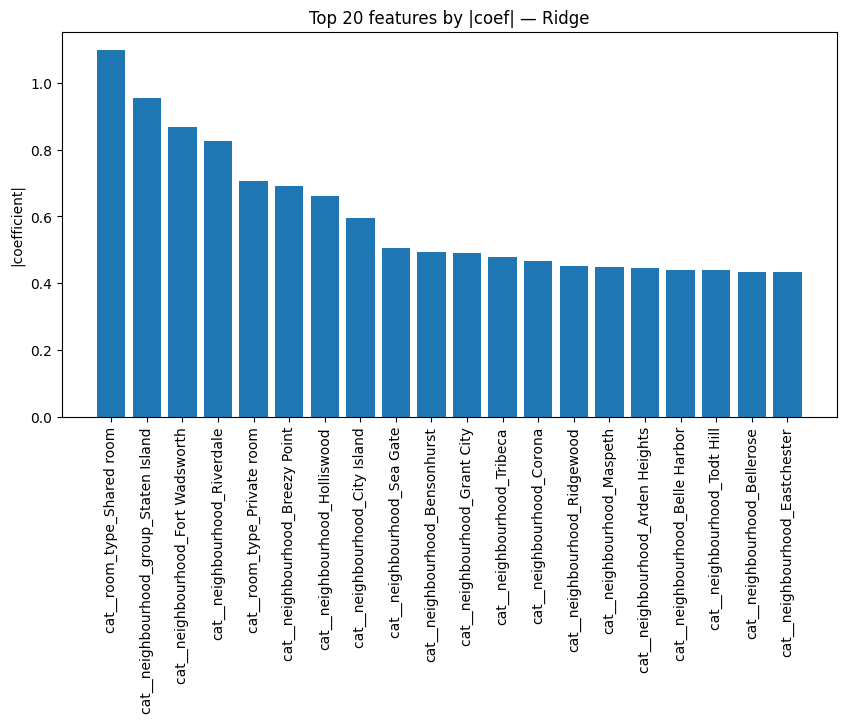

In [70]:
# Optional: plot the top 20 features by absolute coefficient magnitude
top_abs = coef_df.sort_values("abs_coef", ascending=False).head(20)

plt.figure(figsize=(10,5))
plt.bar(top_abs["feature"], top_abs["abs_coef"])
plt.xticks(rotation=90)
plt.ylabel("|coefficient|")
plt.title(f"Top 20 features by |coef| — {best_model_name}")
plt.show()


## [5] Evaluation & Future Steps

### Evaluation (what the numbers mean)
- We report **RMSE** and **R²** on a held-out test set.
- Lower RMSE means predictions are closer to true values.
- Higher R² means the model explains more variation in the target.

### Limitations
- Linear models capture only linear relationships; price can depend on interactions (e.g., location × room type).
- One-hot encoded categories can be sparse; rare categories may lead to unstable coefficients.
- The dataset is from **2019**; patterns may shift over time.

### Future Steps
- Add stronger feature engineering (e.g., clip extreme prices, richer review features, better location granularity).
- Report **cross-validated** metrics (mean ± std) to show stability.
- Try controlled nonlinear extensions (polynomial features on numeric columns only) while keeping interpretability.


Copyright @ IBM Corporation. All rights reserved.
